In [1]:
import torch
import pytorch_lightning as pl
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import CSVLogger
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
class BreaKHisDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, transform, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage= None):
        breakhis_full = ImageFolder(self.data_dir, transform = self.transform)
        train_size = round(len(breakhis_full) * 0.56)
        val_size = round(len(breakhis_full) * 0.14)
        test_size = round(len(breakhis_full) * 0.3)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(breakhis_full, [train_size, val_size, test_size])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [4]:
data_dir = './BreaKHis/'
breakhis_dm = BreaKHisDataModule(data_dir=data_dir, transform=data_transforms, batch_size=32)
breakhis_dm.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


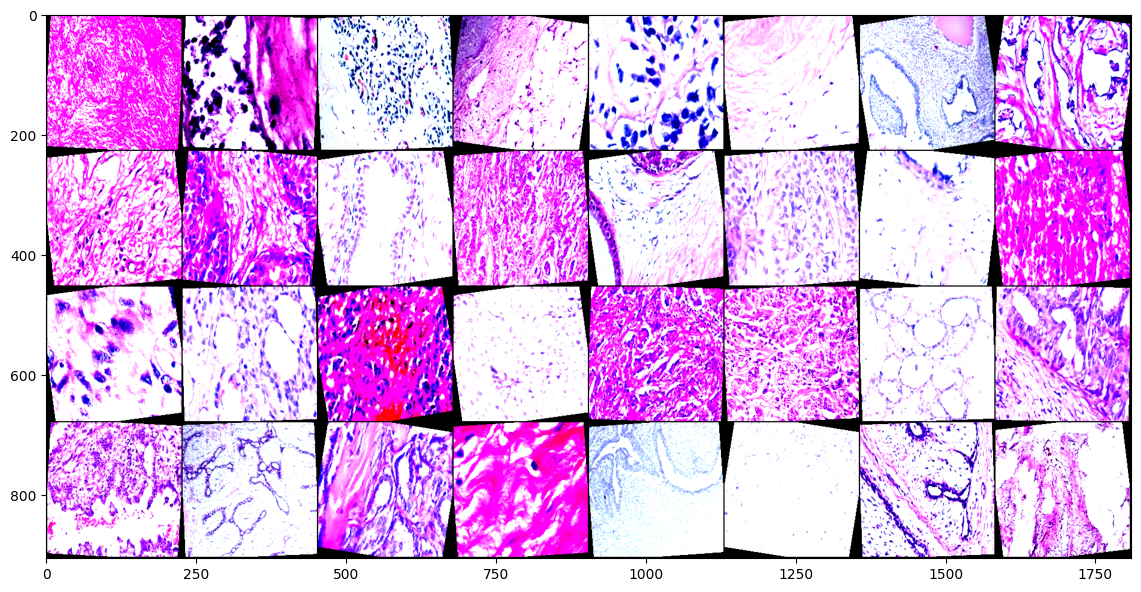

In [7]:
def display_images(dataloader):
    for images, labels in dataloader:
        figure, axis = plt.subplots(figsize = (14, 8))
        axis.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

display_images(breakhis_dm.train_dataloader())

In [19]:
from pl_bolts.models.self_supervised import SimCLR

class SimCLRClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
        simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)
        self.backbone = simclr
        self.finetune_layer = torch.nn.Linear(2048, num_classes)

    def forward(self, x):
        if self.trainer.current_epoch < 15:
            with torch.no_grad():
                  features = self.backbone(x)
        else:
            features = self.backbone(x)
        logits = self.finetune_layer(features)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   
        features = self.backbone(x)
        logits = self.finetune_layer(features)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)

        return {'test_loss': loss, 'test_acc': accuracy_score}
    
    def test_epoch_end(self, outputs):
        avg_test_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        self.log('test_loss', avg_test_loss, prog_bar=True)
        self.log('test_acc', avg_test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)
        
        return optimizer

In [20]:
from pl_bolts.models.self_supervised import SwAV

class SwAVClassifier(pl.LightningModule):
    def __init__(self, num_classes, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt'
        swav = SwAV.load_from_checkpoint(weight_path, strict=False)
        self.backbone = swav.model
        self.finetune_layer = torch.nn.Linear(3000,num_classes)

    def forward(self, x):
        if self.trainer.current_epoch < 15:
            with torch.no_grad():
                  features = self.backbone(x)[-1]
        else:
            features = self.backbone(x)[-1]
        logits = self.finetune_layer(features)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   
        features = self.backbone(x)[-1]
        logits = self.finetune_layer(features)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)

        return {'test_loss': loss, 'test_acc': accuracy_score}
    
    def test_epoch_end(self, outputs):
        # Calculate average test loss and accuracy across all batches
        avg_test_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        # Log the test results
        self.log('test_loss', avg_test_loss, prog_bar=True)
        self.log('test_acc', avg_test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)
        
        return optimizer

In [21]:
class DINOV2Classifier(pl.LightningModule):
    def __init__(self, num_classes, lr = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.backbone = dinov2
        self.head = torch.nn.Linear(384, num_classes)
        self.head.weight.data.normal_(mean=0.0, std=0.01)
        self.head.bias.data.zero_()

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        logits = self.head(features)
        return logits
            
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'train_loss': loss, 'train_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch   
        features = self.backbone(x)
        logits = self.head(features)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)
        metrics = {'valid_loss': loss, 'valid_acc': accuracy_score}
        self.log_dict(metrics, on_step = False, on_epoch = True, 
                      prog_bar = True, logger = True)
        
        return metrics
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = cross_entropy(logits, y)
        accuracy_score = accuracy(logits, y)

        return {'test_loss': loss, 'test_acc': accuracy_score}
    
    def test_epoch_end(self, outputs):
        # Calculate average test loss and accuracy across all batches
        avg_test_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        # Log the test results
        self.log('test_loss', avg_test_loss, prog_bar=True)
        self.log('test_acc', avg_test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr = self.hparams.lr)
        return optimizer

In [22]:
num_classes = 8
simclr_logger = CSVLogger(save_dir = './breakhis_log', name = 'simclr_v1')
swav_logger = CSVLogger(save_dir = './breakhis_log', name = 'swav_v1')
dinov2_logger = CSVLogger(save_dir = './breakhis_log', name = 'dinov2_v1')

In [23]:
simclr_classifier = SimCLRClassifier(num_classes=num_classes)
simclr_trainer = pl.Trainer(max_epochs = 30,
                     limit_train_batches = 32, 
                     log_every_n_steps = 10, logger = simclr_logger, accelerator='mps')
simclr_trainer.fit(simclr_classifier, breakhis_dm)
torch.save(simclr_classifier.state_dict(), "./simclr_breakhis_v1.pt")

/Users/kennyyeung/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolt

Epoch 29: 100%|██████████| 67/67 [01:25<00:00,  1.27s/it, loss=0.346, v_num=3, valid_loss=0.480, valid_acc=0.817, train_loss=0.367, train_acc=0.873]

`Trainer.fit` stopped: `max_epochs=30` reached.
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 67/67 [01:25<00:00,  1.28s/it, loss=0.346, v_num=3, valid_loss=0.480, valid_acc=0.817, train_loss=0.367, train_acc=0.873]


In [24]:
swav_classifier = SwAVClassifier(num_classes=num_classes)
swav_trainer = pl.Trainer(max_epochs = 30,
                     limit_train_batches = 32, 
                     log_every_n_steps = 10, logger = swav_logger, accelerator='mps')
swav_trainer.fit(swav_classifier, breakhis_dm)
torch.save(swav_classifier.state_dict(), "./swav_breakhis_v1.pt")

Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt`
GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs

  | Name           | Type   | Params
------------------------------------------
0 | backbone       | ResNet | 28.

Epoch 29: 100%|██████████| 67/67 [01:25<00:00,  1.28s/it, loss=0.543, v_num=1, valid_loss=0.477, valid_acc=0.826, train_loss=0.537, train_acc=0.801]

`Trainer.fit` stopped: `max_epochs=30` reached.
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 67/67 [01:26<00:00,  1.28s/it, loss=0.543, v_num=1, valid_loss=0.477, valid_acc=0.826, train_loss=0.537, train_acc=0.801]


In [25]:
dinov2_classifier = DINOV2Classifier(num_classes=num_classes)
dinov2_trainer = pl.Trainer(max_epochs = 30,
                     limit_train_batches = 32, 
                     log_every_n_steps = 10, logger = dinov2_logger, accelerator='cpu')
dinov2_trainer.fit(dinov2_classifier, breakhis_dm)
torch.save(dinov2_classifier.state_dict(), "./dinov2_breakhis_v1.pt")

Using cache found in /Users/kennyyeung/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available
GPU available: True (mps), used: False
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
/Users/kennyyeung/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name     | Type                  | Params
---------------------------------------------------
0 | backbone | DinoVisionTransformer | 22.1 M
1 | head     | Linear                | 3.1 K 
---------------------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
8

Epoch 29: 100%|██████████| 67/67 [02:13<00:00,  1.99s/it, loss=0.879, v_num=1, valid_loss=0.908, valid_acc=0.691, train_loss=0.888, train_acc=0.671]

`Trainer.fit` stopped: `max_epochs=30` reached.
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 67/67 [02:13<00:00,  1.99s/it, loss=0.879, v_num=1, valid_loss=0.908, valid_acc=0.691, train_loss=0.888, train_acc=0.671]


In [24]:
def create_graph(logger_path, name):
    training_metrics = pd.read_csv(f'{logger_path}/metrics.csv')
    train_loss = training_metrics['train_loss'].dropna().reset_index(drop = True)
    train_acc = training_metrics['train_acc'].dropna().reset_index(drop = True)
    valid_loss = training_metrics['valid_loss'].dropna().reset_index(drop = True)
    valid_acc = training_metrics['valid_acc'].dropna().reset_index(drop = True)  
    figure = plt.figure(figsize = (12, 6))
    plt.title(f'{name} Accuracies', fontsize=28)
    plt.xlabel('Epoch', fontsize = 24)
    plt.ylabel('Accuracy', fontsize = 24)
    plt.plot(train_acc, color = 'g', marker = 'x', label = 'Training Accuracy')
    plt.plot(valid_acc, color = 'm', marker = 'o', label = 'Validation Accuracy')
    plt.legend(loc = 'lower right', fontsize = 18)
    plt.grid(True)
    plt.savefig(f'{logger_path}/accuracy_{name}.png')
    train_loss = training_metrics['train_loss'].dropna().reset_index(drop = True)
    valid_loss = training_metrics['valid_loss'].dropna().reset_index(drop = True)
    fig = plt.figure(figsize = (12, 6))
    title = "{title_name} Loss".format(title_name = name)
    plt.title(title, fontsize=28)
    plt.xlabel('Epoch', fontsize = 24)
    plt.ylabel('Loss', fontsize = 24)
    plt.plot(train_loss, color = 'g', marker = 'x', label = 'Training Loss')
    plt.plot(valid_loss, color = 'm', marker = 'o', label = 'Validation Loss')
    plt.legend(loc = 'upper right', fontsize = 18)
    plt.grid(True)
    plt.savefig(f'{logger_path}/loss_{name}.png')

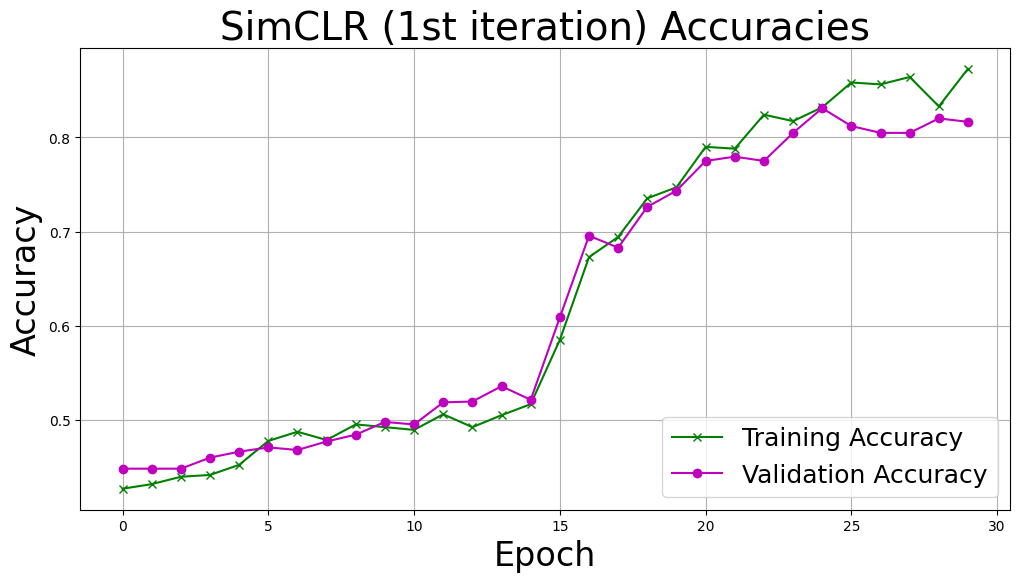

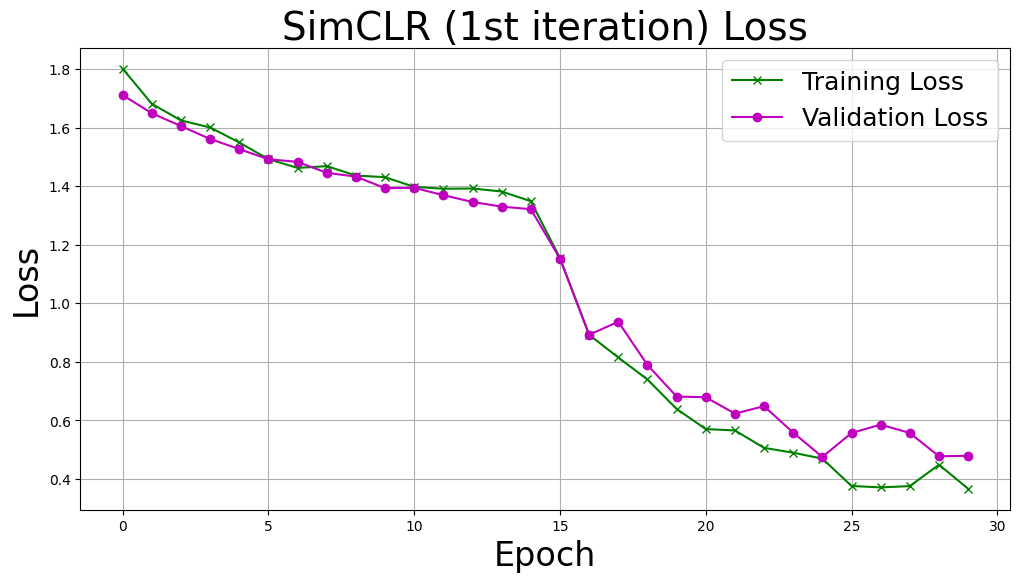

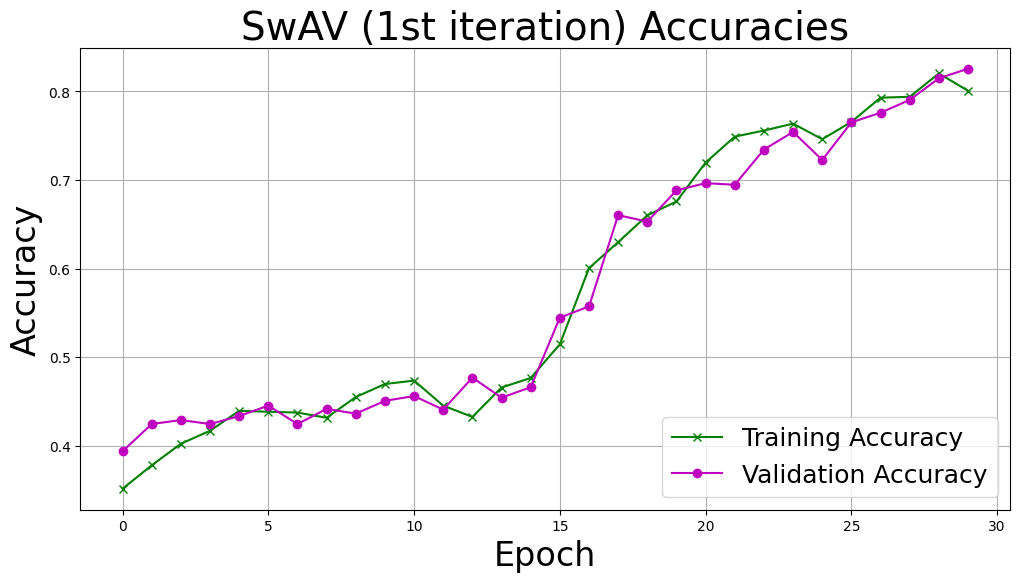

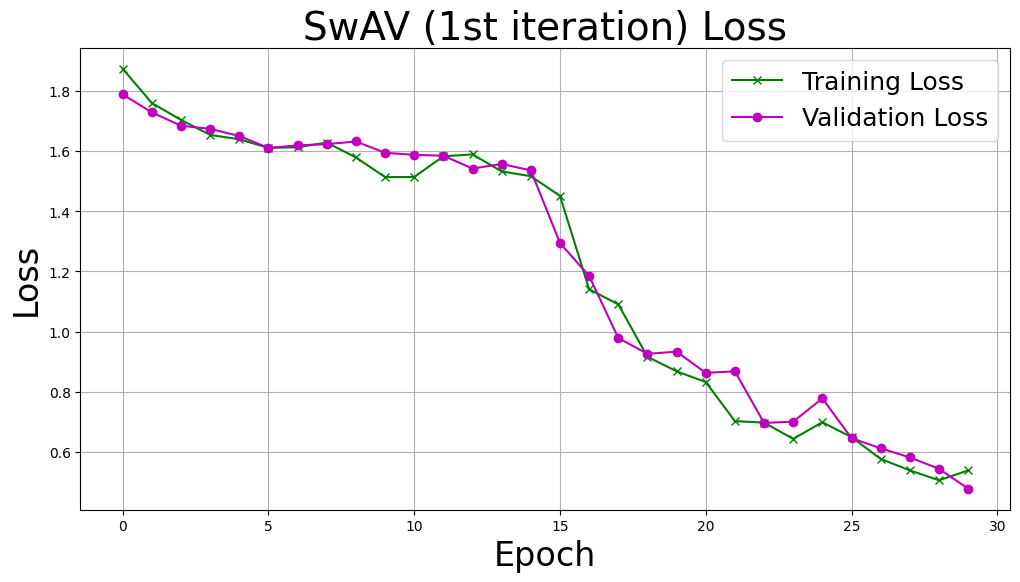

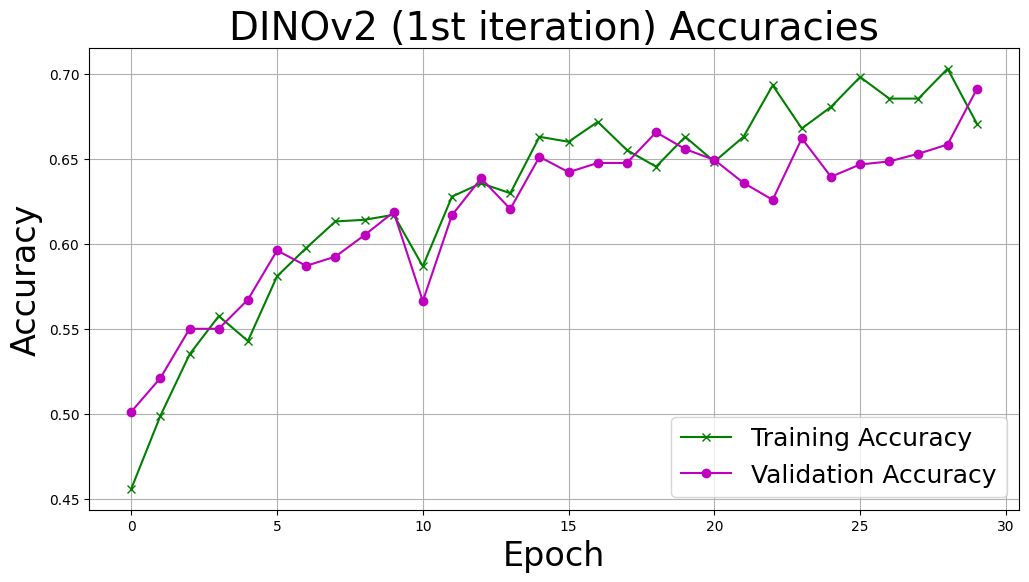

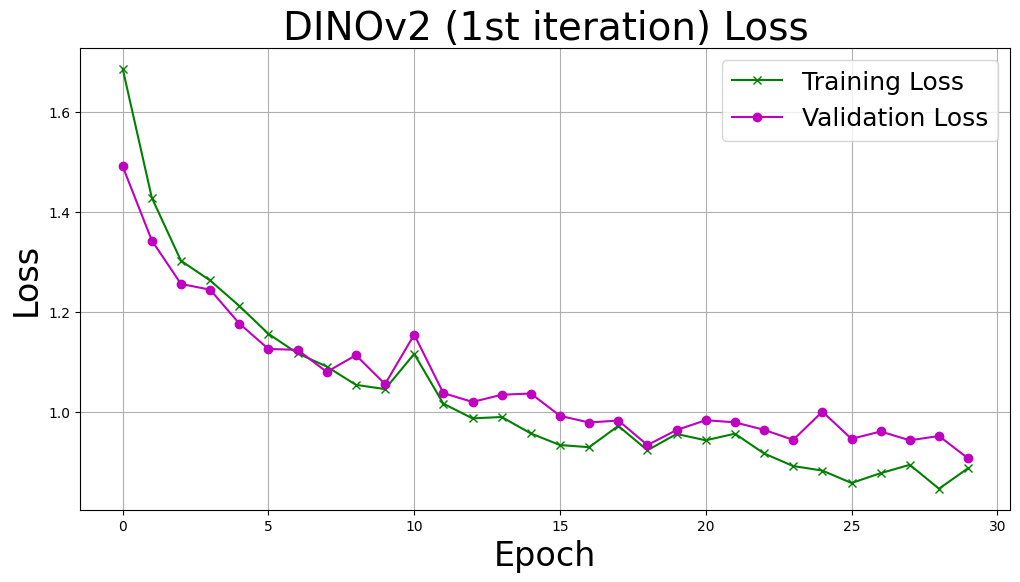

In [26]:
create_graph('./breakhis_log/simclr_v1/version_3', "SimCLR (1st iteration)")
create_graph('./breakhis_log/swav_v1/version_1', "SwAV (1st iteration)")
create_graph('./breakhis_log/dinov2_v1/version_1', "DINOv2 (1st iteration)")

In [28]:
simrclr_state_dict = torch.load('./simclr_breakhis_v1.pt')
simclr_model = SimCLRClassifier(num_classes=8)
simclr_model.load_state_dict(simrclr_state_dict)
simclr_trainer.test(simclr_model, breakhis_dm.test_dataloader())

/Users/kennyyeung/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolt

Testing DataLoader 0: 100%|██████████| 75/75 [00:19<00:00,  3.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8595000505447388     │
│         test_loss         │    0.37993553280830383    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.37993553280830383, 'test_acc': 0.8595000505447388}]

In [29]:
swav_state_dict = torch.load('./swav_breakhis_v1.pt')
swav_model = SwAVClassifier(num_classes=8)
swav_model.load_state_dict(swav_state_dict)
swav_trainer.test(swav_model, breakhis_dm.test_dataloader())

Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.0.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file https:/pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt`


Testing DataLoader 0: 100%|██████████| 75/75 [00:19<00:00,  3.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8387500047683716     │
│         test_loss         │    0.43462830781936646    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43462830781936646, 'test_acc': 0.8387500047683716}]

In [30]:
dinov2_state_dict = torch.load('./dinov2_breakhis_v1.pt')
dinov2_model = DINOV2Classifier(num_classes=8)
dinov2_model.load_state_dict(dinov2_state_dict)
dinov2_trainer.test(dinov2_model, breakhis_dm.test_dataloader())

Using cache found in /Users/kennyyeung/.cache/torch/hub/facebookresearch_dinov2_main


Testing DataLoader 0: 100%|██████████| 75/75 [01:39<00:00,  1.33s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7019166350364685     │
│         test_loss         │    0.8417029976844788     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8417029976844788, 'test_acc': 0.7019166350364685}]